In [1]:
import torch, math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
!pip install torchsummary
from torchsummary import summary
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
!pip install torchsummary
from torchsummary import summary
!pip install einops
from math import ceil
# !pip install nystrom-attention

from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from einops import rearrange, reduce

# helpers
from einops import reduce

transform = transforms.Compose(
        [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def accuracy(output, target, topk=(1,5)):
    """Computes the precision@k for the specified values of k
    prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
    """
    maxk = max(topk)
         # sizefunction: the number of total elements
    batch_size = target.size(0) 
 
         # topk function selects the number of k before output
    _, pred = output.topk(maxk, 1, True, True)
         ##########Do not understand t()k
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))   
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
def exists(val):
    return val is not None

def rotate_every_two(x):
    x = rearrange(x, '... (d j) -> ... d j', j = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d j -> ... (d j)')

def apply_rotary_pos_emb(q, k, sinu_pos):
    sinu_pos = rearrange(sinu_pos, '() n (j d) -> n j d', j = 2)
    sin, cos = sinu_pos.unbind(dim = -2)

    sin, cos = map(lambda t: repeat(t, 'b n -> b (n j)', j = 2), (sin, cos))
    q, k = map(lambda t: (t * cos) + (rotate_every_two(t) * sin), (q, k))
    return q, k

class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        position = torch.arange(0, max_seq_len, dtype=torch.float)
        sinusoid_inp = torch.einsum("i,j->ij", position, inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        self.register_buffer('emb', emb)

    def forward(self, x):
        return self.emb[None, :x.shape[1], :].to(x)


In [3]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x, pos_emb = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        if exists(pos_emb):
            q, k = apply_rotary_pos_emb(q, k, pos_emb)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x, pos_emb):
        for attn, ff in self.layers:
            x = attn(x, pos_emb = pos_emb) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., rotary_position_emb = True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        max_seq_len = 1025
        if rotary_position_emb:
            self.layer_pos_emb = FixedPositionalEmbedding(dim_head, max_seq_len)


    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
#         x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        layer_pos_emb = self.layer_pos_emb(x)
        x = self.transformer(x, pos_emb = layer_pos_emb)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [4]:

model = ViT(
    image_size = 32,
    patch_size = 1,
    num_classes = 10,             # number of stages
    dim = 128,  # dimensions at each stage
    depth = 4,              # transformer of depth 4 at each stage
    heads = 4,      # heads at each stage
    mlp_dim = 256,
    dropout = 0.,
    dim_head = 32
)


model.to(device)
print(summary(model, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 1024, 3]               0
            Linear-2            [-1, 1024, 128]             512
           Dropout-3            [-1, 1025, 128]               0
FixedPositionalEmbedding-4             [-1, 1025, 32]               0
         LayerNorm-5            [-1, 1025, 128]             256
            Linear-6            [-1, 1025, 384]          49,152
           Softmax-7        [-1, 4, 1025, 1025]               0
            Linear-8            [-1, 1025, 128]          16,512
           Dropout-9            [-1, 1025, 128]               0
        Attention-10            [-1, 1025, 128]               0
          PreNorm-11            [-1, 1025, 128]               0
        LayerNorm-12            [-1, 1025, 128]             256
           Linear-13            [-1, 1025, 256]          33,024
             GELU-14            [

In [6]:
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
top1 = []
top5 = []
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
for epoch in range(40):  # loop over the dataset multiple times
    t0 = time.time()
    epoch_accuracy = 0
    epoch_loss = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        with torch.cuda.amp.autocast():
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    correct = 0
    total = 0
    correct_1=0
    correct_5=0
    c = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
#         outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            res = accuracy(outputs, labels)
            correct_1 += res[0][0].float()
            correct_5 += res[1][0].float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c += 1
        
    print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - Top 1: {correct_1/c} - Top 5: {correct_5/c} - Time: {time.time() - t0}\n")
    top1.append(correct_1/c)
    top5.append(correct_5/c)
    if float(correct_1/c) >= float(max(top1)):
        PATH = 'ViTRoPE.pth'
        torch.save(model.state_dict(), PATH)
        print(1)
print('Finished Training')

[1,   200] loss: 0.180
[1,   400] loss: 0.156
[1,   600] loss: 0.148
Epoch : 1 - loss : 1.5637 - acc: 0.4322 - Top 1: 51.60231018066406 - Top 5: 93.88933563232422 - Time: 601.937352180481

1
[2,   200] loss: 0.132
[2,   400] loss: 0.130
[2,   600] loss: 0.125
Epoch : 2 - loss : 1.2694 - acc: 0.5409 - Top 1: 56.0410041809082 - Top 5: 95.0338363647461 - Time: 605.5865170955658

1
[3,   200] loss: 0.116
[3,   400] loss: 0.113
[3,   600] loss: 0.112
Epoch : 3 - loss : 1.1307 - acc: 0.5935 - Top 1: 60.36027145385742 - Top 5: 96.33757781982422 - Time: 606.2064626216888

1
[4,   200] loss: 0.103
[4,   400] loss: 0.104
[4,   600] loss: 0.104
Epoch : 4 - loss : 1.0305 - acc: 0.6316 - Top 1: 62.10191345214844 - Top 5: 96.47691345214844 - Time: 605.1131565570831

1
[5,   200] loss: 0.095
[5,   400] loss: 0.097
[5,   600] loss: 0.097
Epoch : 5 - loss : 0.9565 - acc: 0.6574 - Top 1: 63.972930908203125 - Top 5: 96.49681854248047 - Time: 605.3441059589386

1
[6,   200] loss: 0.087
[6,   400] loss: 0.

KeyboardInterrupt: ignored

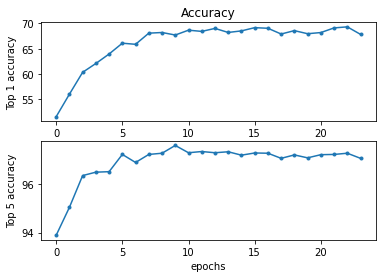

In [8]:
plt.subplot(2, 1, 1)
plt.plot(top1, '.-')
plt.title('Accuracy')
plt.ylabel('Top 1 accuracy')

plt.subplot(2, 1, 2)
plt.plot(top5, '.-')
plt.xlabel('epochs')
plt.ylabel('Top 5 accuracy')

plt.show()